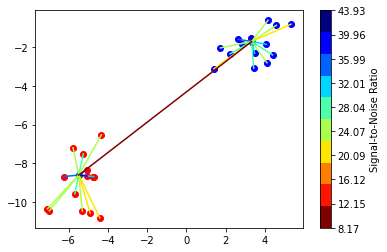

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from modifying_KMeans_snr import cluster_former
import copy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 30
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'noniid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.csi_low=0
        self.csi_high=1

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


/home/iiitd/anaconda3/envs/FL/lib/python3.8/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=True, download=True, transform=transform)
global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [8]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [9]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return(100. * correct / len(test_loader.dataset))

In [10]:
torch.manual_seed(args.torch_seed)

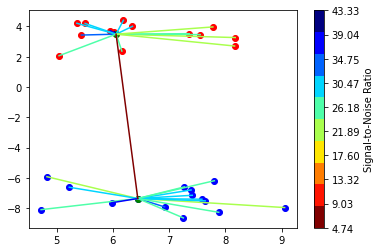

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.344537
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 2.006331


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  to_return = self.native_grad


Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.582730

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.309791
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 2.132803
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.303964

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.256909
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 2.061519
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.152708

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss: 2.335974
Model client10 Train Epoch: 2 [0/320 (0%)]	Loss: 1.822472


/tmp/ipykernel_245281/3032248498.py:65: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client10 Train Epoch: 3 [0/320 (0%)]	Loss: 0.996121

Power Allocated= 0.45370256213513294
CSI= 0.24555465499491547
SNR= 20.782535387998347
Client: client11
Model client11 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280982
Model client11 Train Epoch: 2 [0/320 (0%)]	Loss: 1.814541
Model client11 Train Epoch: 3 [0/320 (0%)]	Loss: 1.053824

Power Allocated= 2.945977621722526
CSI= 0.6328560912789477
SNR= 31.3532075970829
Client: client12
Model client12 Train Epoch: 1 [0/320 (0%)]	Loss: 2.204292
Model client12 Train Epoch: 2 [0/320 (0%)]	Loss: 2.024879
Model client12 Train Epoch: 3 [0/320 (0%)]	Loss: 1.180525

Power Allocated= 3.1080586610225622
CSI= 0.7051902577372571
SNR= 26.771374664504357
Client: client16
Model client16 Train Epoch: 1 [0/320 (0%)]	Loss: 2.410525
Model client16 Train Epoch: 2 [0/320 (0%)]	Loss: 2.185699
Model client16 Train Epoch: 3 [0/320 (0%)]	Loss: 1.391574

Power Allocated= 3.366935919278454
CSI= 0.8626789626593053
SNR= 37.83496452697601
Client: client17
Model client17 

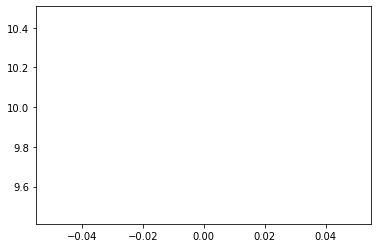

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.308689
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.404869
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.967153

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.296656
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.794171
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.735647

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

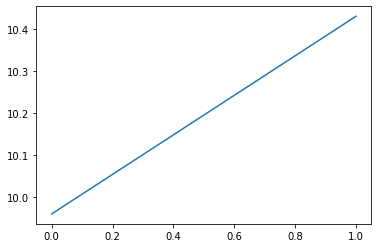

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.302113
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.924718
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.418166

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.299387
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 2.091015
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.821964

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.305874
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.827460
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.474576

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


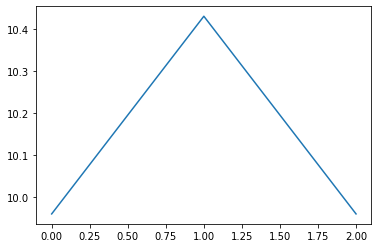

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.296283
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.543096
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.913700

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.289020
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.804982
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.446210

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

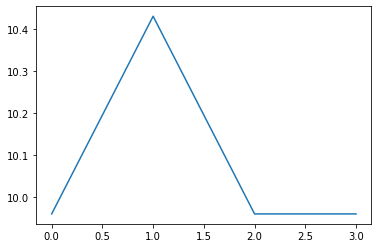

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.294032
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.295871
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.645144

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.290786
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.801697
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.488043

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.306908
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 2.085990
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.831739

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


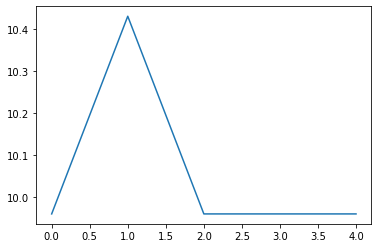

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.290625
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.030635
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.553337

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280342
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.709906
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.315644

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

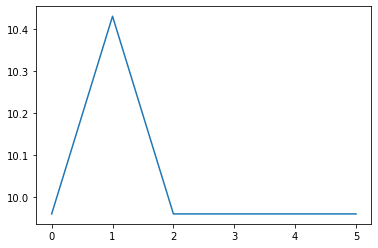

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.288404
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.132191
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.758138

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.264335
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.602806
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.206554

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

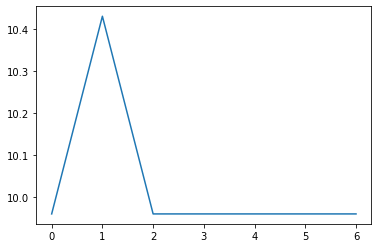

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.291670
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.986592
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.738332

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.269790
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.516424
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.149865

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

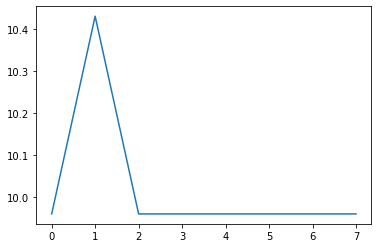

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.290494
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.937293
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.653265

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.275311
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.429334
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.127770

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

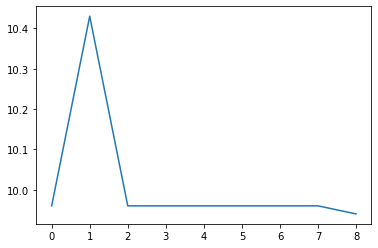

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.289421
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.814939
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.591683

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.282521
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.375618
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.114752

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

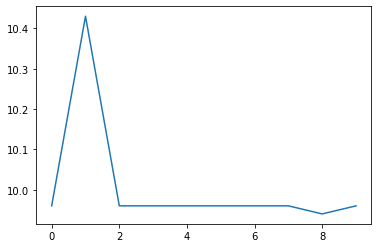

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.290826
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.844702
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.945578

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.282152
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.334694
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.106063

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

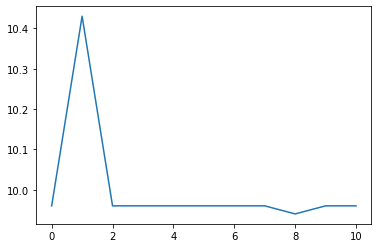

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293365
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.780752
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.669001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.265352
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.293427
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.105865

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

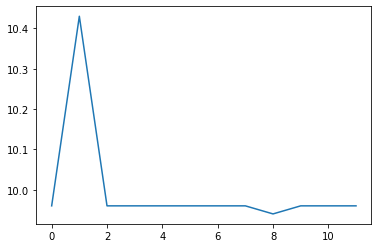

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.294249
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.699087
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.691066

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.257527
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.282398
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.102550

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.342333
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.808078
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.552237

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


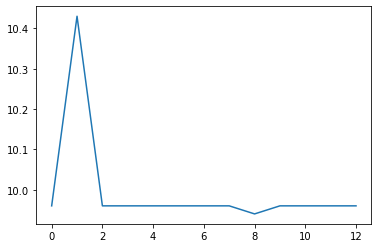

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278917
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.734970
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.686676

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.213959
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.226927
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.106640

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

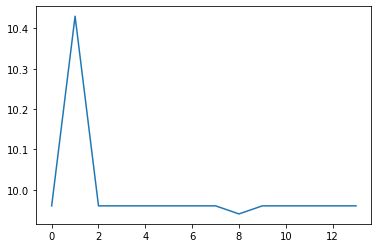

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.291830
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.864215
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.976460

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.236706
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.170959
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.097441

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

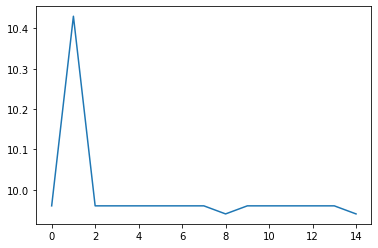

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278254
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.730842
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.784704

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.240798
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.195694
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.086190

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.342019
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.673460
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.308734

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


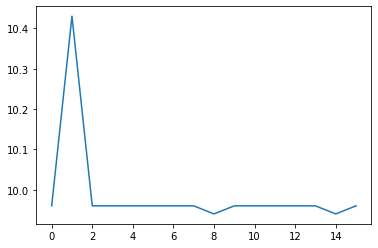

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.303684
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.660152
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.195930

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.245346
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.164877
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.108309

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

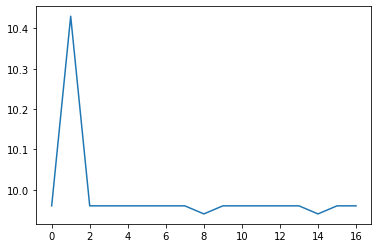

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.308541
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.721229
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.793023

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.267730
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.149379
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.095241

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

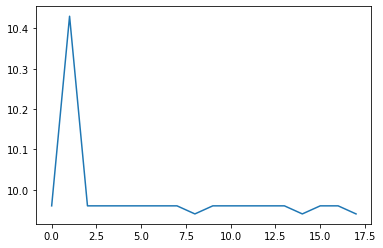

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.304126
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.811599
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.794295

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.265953
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.163537
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.101705

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

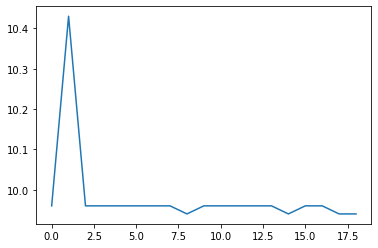

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.267620
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.699431
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.835909

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.242318
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.152498
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.106884

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

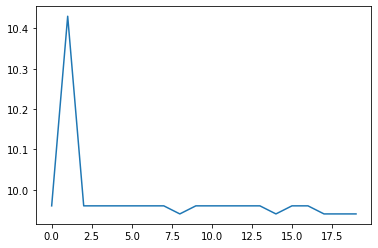

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.281389
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.808080
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.625296

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.241600
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.136453
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.181770

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

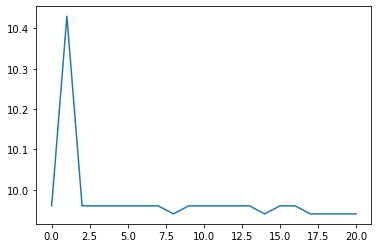

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278066
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.661847
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.673086

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.225661
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.119547
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.127893

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

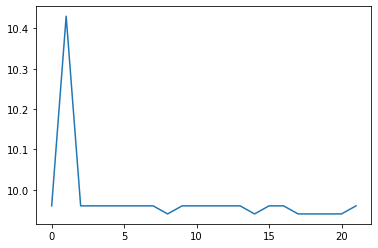

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.292886
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.656671
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.845061

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.220520
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.193287
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.170139

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.316220
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.580753
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.114202

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


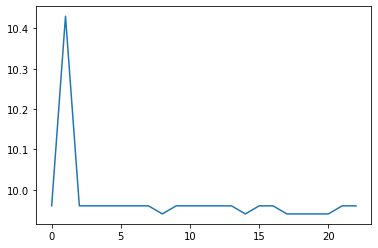

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.311622
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.678550
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.525691

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.205306
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.122812
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.370843

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

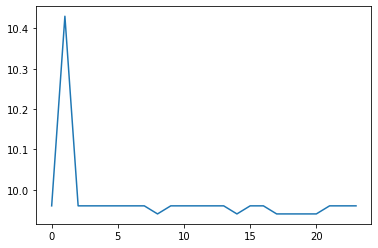

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.258481
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.533685
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.400941

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.249784
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.285638
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.276746

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.353971
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.414956
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.882295

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


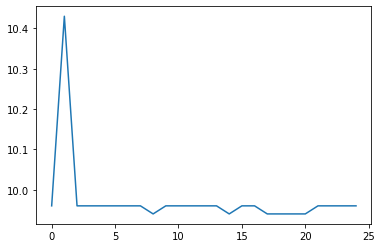

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.238617
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.521369
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.466178

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.236426
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.127249
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.377082

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

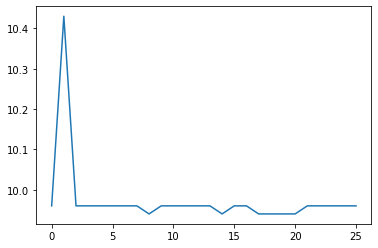

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.290494
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.619936
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.633368

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.257305
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.193205
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.522075

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.325853
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.363907
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.128891

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


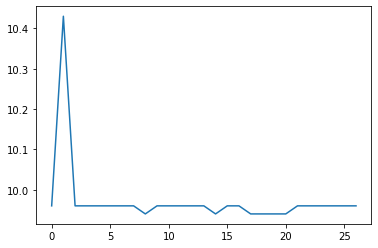

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.253423
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.608858
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.199634

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.209694
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.113711
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.283465

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293800
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.337604
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.393935

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


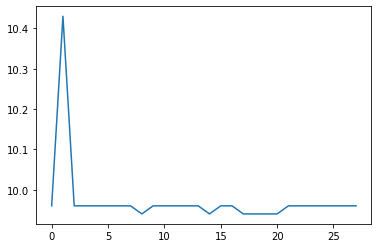

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.291972
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.486345
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.162599

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.237490
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.194337
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.270419

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.268950
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.223755
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.969796

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


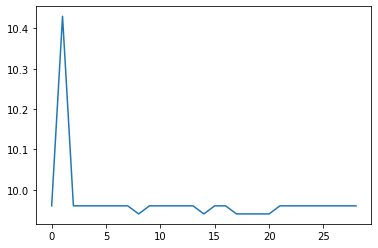

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.285739
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.392925
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.200296

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.227596
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.133753
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.155503

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

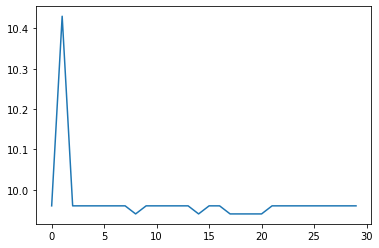

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.276336
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.390818
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.103821

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.254329
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.255660
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.376956

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

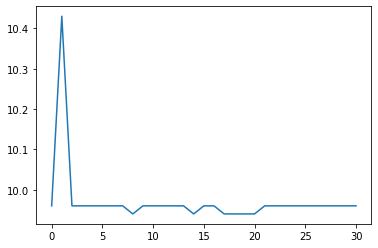

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280481
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.312116
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.022501

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.242865
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.120701
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.320765

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

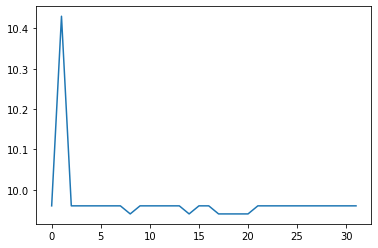

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.242399
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.324579
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.065141

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.274926
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.127686
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.144035

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

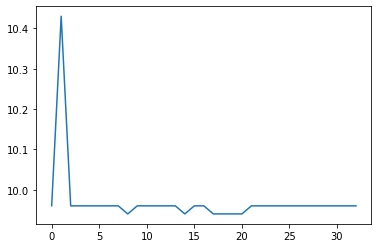

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.244700
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.213043
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.101276

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.242134
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.093025
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.146547

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

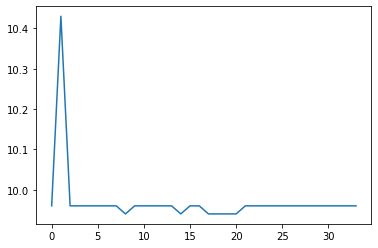

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.288517
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.238567
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.105834

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.275643
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.061093
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.199849

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.375412
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.281681
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.998065

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


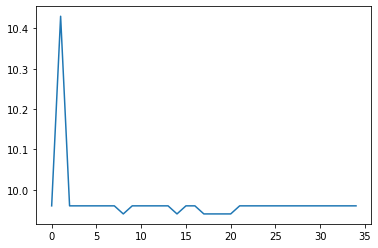

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.254874
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.184105
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.035880

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.218185
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.108925
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.704963

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

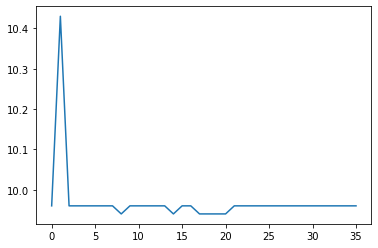

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.269052
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.289267
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.069838

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.218407
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.077377
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.995463

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

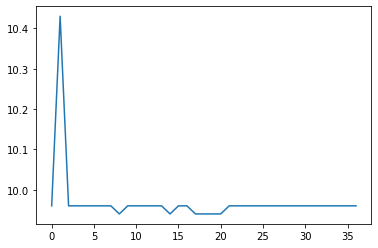

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.251820
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.179440
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.070563

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.273219
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.903533
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.285364

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

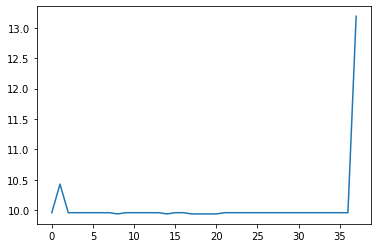

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.271643
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.252993
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.097835

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.195535
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.827408
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.325264

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

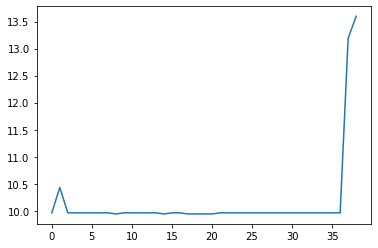

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.278367
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.134048
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.073764

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.226694
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.610580
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.259438

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

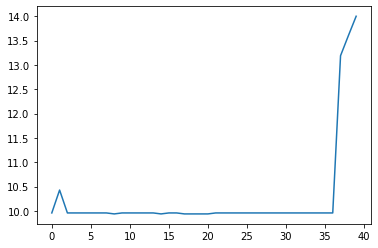

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.245535
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.126940
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.032846

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.232586
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.732788
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.277307

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

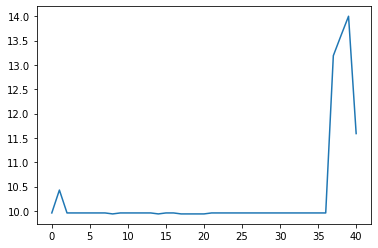

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.275386
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.084956
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.080191

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280861
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.545335
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.110558

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

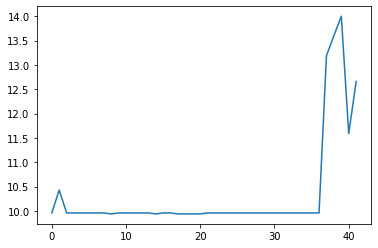

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.267913
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.116015
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.058517

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199513
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.604601
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.290987

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

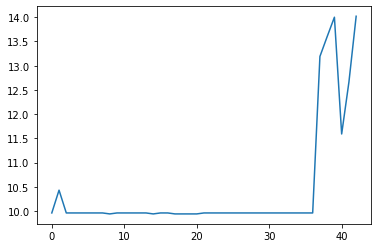

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.288309
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.053030
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.029034

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.238811
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.399936
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.149647

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

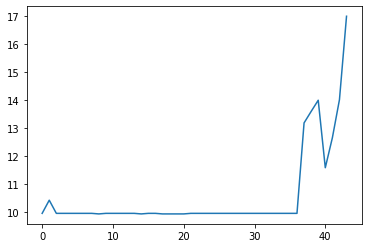

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.280622
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.091887
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001200

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.211274
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.406605
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.648393

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

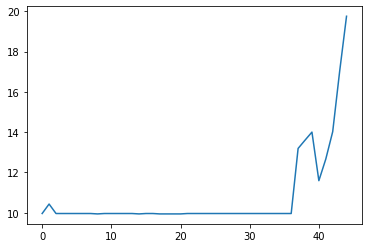

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.264620
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.057050
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.095778

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.201368
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.227330
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.330735

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

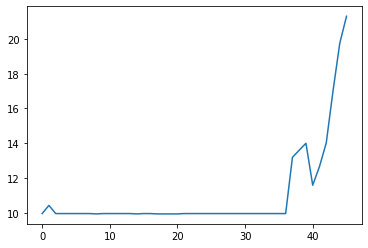

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.240532
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.043831
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.044799

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.173124
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.305919
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.146077

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

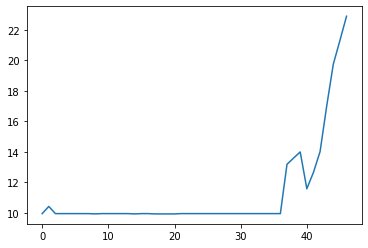

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.221913
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.066161
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.015873

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.184904
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.522026
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.025328

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.317586
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.080774
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.609975

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


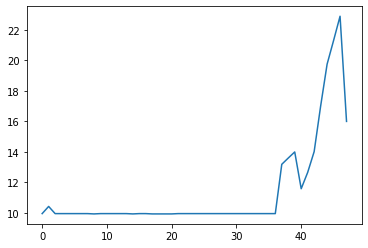

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.231200
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006976
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.131314

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.130329
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.197335
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.344238

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

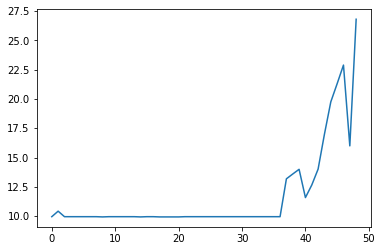

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.216674
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.044024
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.054043

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.203409
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.143840
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.505090

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.295309
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.906091
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.908499

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


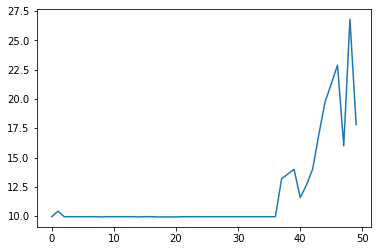

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.185681
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.058646
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.082521

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.092093
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.079603
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.008796

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

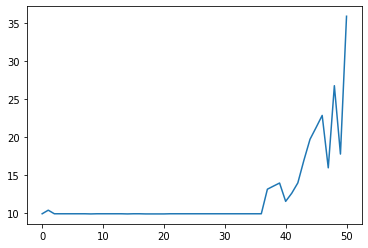

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.238677
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.053495
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.033484

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.117639
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.105670
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001635

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

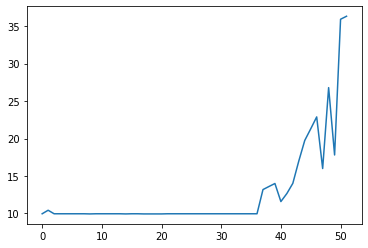

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.169785
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.012665
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.015456

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.122962
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.098510
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.074968

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.293203
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.190402
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.166762

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


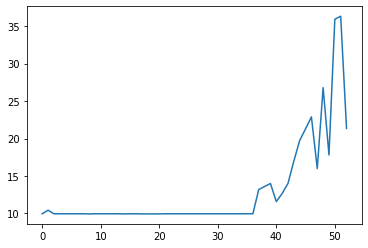

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199553
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.126813
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000014

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.112347
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.082247
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.016396

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

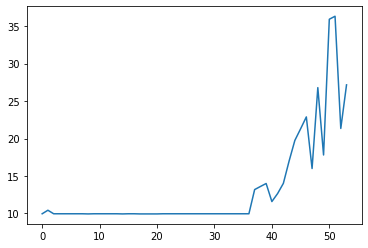

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.237215
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.185964
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000025

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.179554
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.240233
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.173811

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.331523
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.139559
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.939193

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


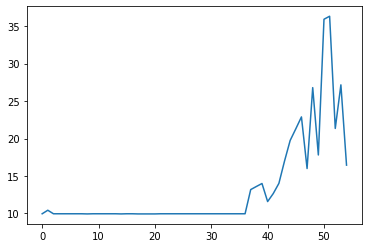

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.218405
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.010997
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.098666

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.078128
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.160534
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.126926

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

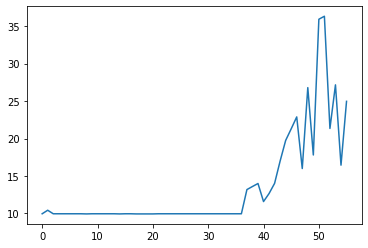

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199889
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.071062
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001704

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.091817
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.180458
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.046616

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.313053
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.975565
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.651572

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


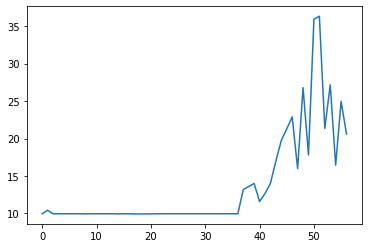

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.199435
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.025386
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000013

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.135572
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.093526
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.025420

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

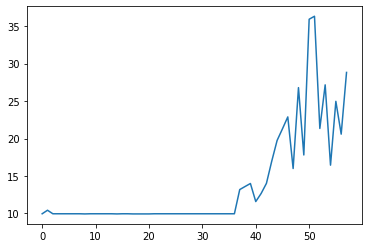

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.192282
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.580097
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.083266

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.139527
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.043336
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.032058

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

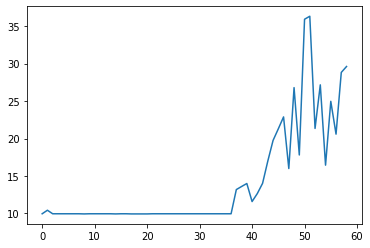

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.143552
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.569116
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.092608

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.092062
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.064062
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.052007

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

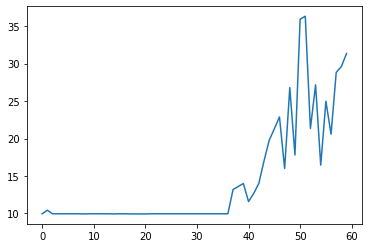

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.135625
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.060152
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.058701

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.065760
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.062726
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000028

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

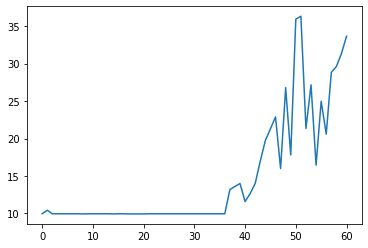

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.161574
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.125815
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.115955

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.062000
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009741
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000086

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

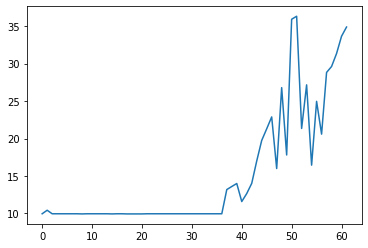

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.195012
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004251
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.044769

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.995554
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.067522
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.014005

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

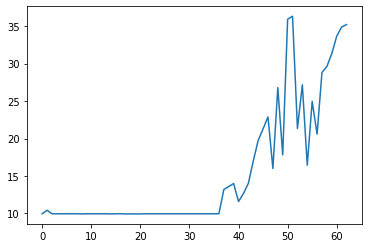

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.153948
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.035589
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000591

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.952918
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.031052
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.279548
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.117983
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.234944

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


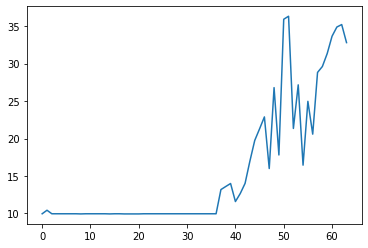

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.111598
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006305
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000957

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.982392
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.017056
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000056

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

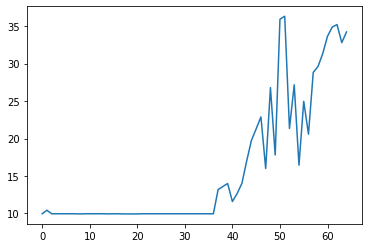

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.153396
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.016508
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.021492

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.014449
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.277503
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000455

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

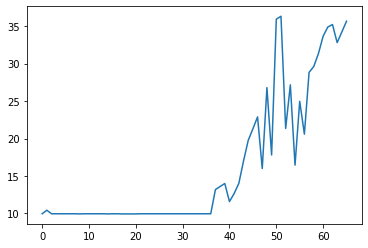

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.083314
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004846
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000981

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.037606
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.016761
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000031

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

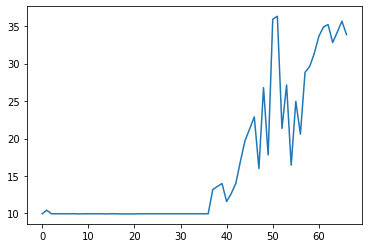

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.108670
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.040142
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.002887

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.014813
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003450
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

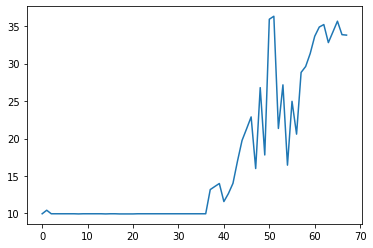

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.096468
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.039157
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000244

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.986853
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005166
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

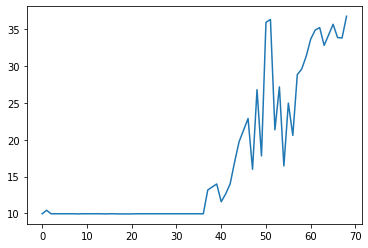

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.088607
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004155
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000121

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.935183
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.917284
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.011799

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

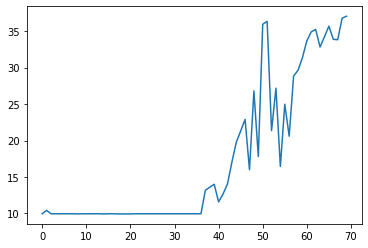

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.060310
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.046613
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000013

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.974253
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.764629
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.631655

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.121555
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.589038
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.193557

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


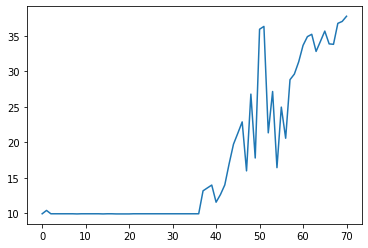

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.060532
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.305500
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000116

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.857781
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.743710
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.372556

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.001836
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.717543
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.386951

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


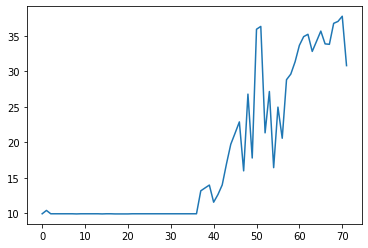

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.990692
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.306573
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.064188

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.839053
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.372499
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.783812

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

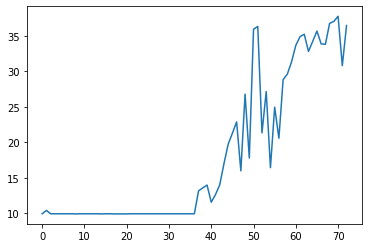

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.013777
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002399
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000372

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.952371
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.220867
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.108379

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.181527
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.665588
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.092113

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


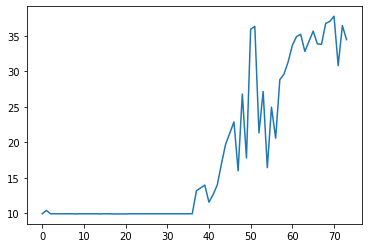

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.046376
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.011993
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000060

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.906453
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.243378
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.123823

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.019760
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.501647
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.131811

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


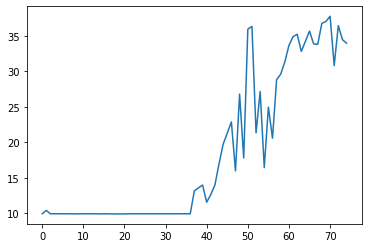

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.021502
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.020666
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000281

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.728993
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.025312
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003457

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

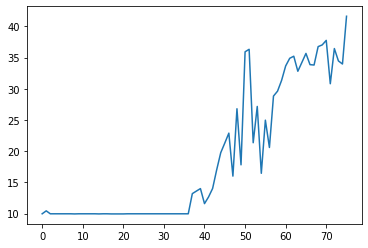

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.953439
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.034791
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000110

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.825555
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008827
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.036519

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

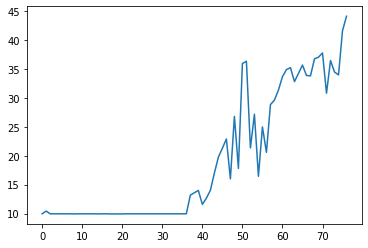

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.878947
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.045573
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000303

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.791943
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004569
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.040550

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.040570
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.540064
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.211303

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


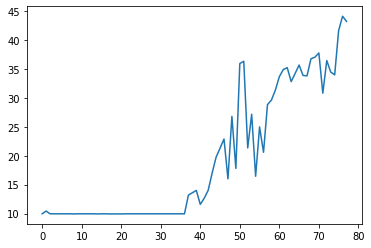

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.791845
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.013998
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000300

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.539031
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.107301
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

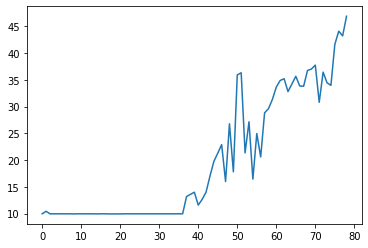

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.841318
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.085968
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000152

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.784572
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.071237
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.040484
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.253309
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.147946

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


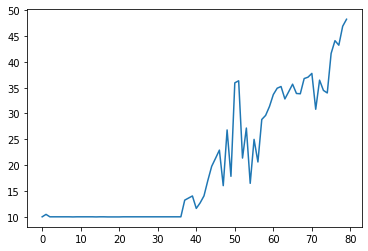

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.796344
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.045331
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.564351
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006255
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000003

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

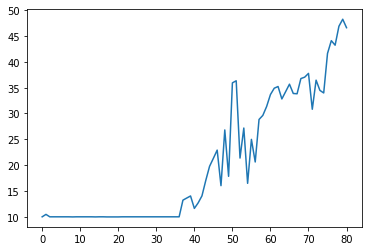

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.883856
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.018638
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.054801

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.776524
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024977
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

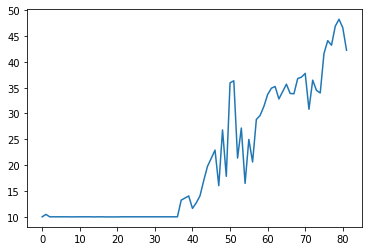

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.095865
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.105108
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.086098
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001847
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000012

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

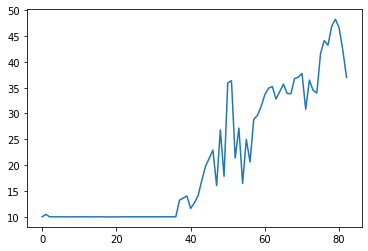

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.046046
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007009
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000054

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.035058
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004426
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

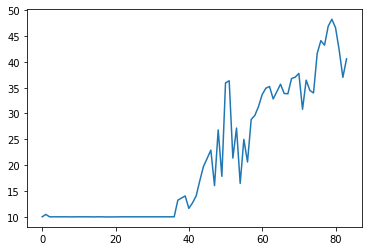

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.026583
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014215
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.021824

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.930189
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001950
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000017

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

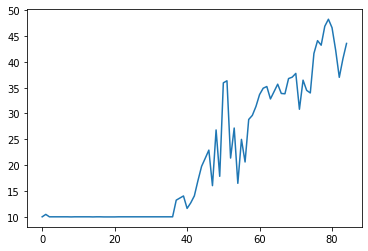

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.011188
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.337361
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.217171

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.909909
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000741
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

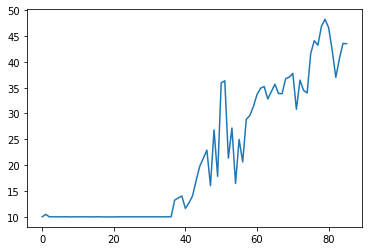

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.016311
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.105402
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.081419

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.884250
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008856
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.088800
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.114067
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.009726

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


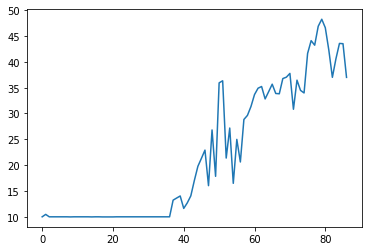

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.078893
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.114512
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.143703

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.847490
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.085236
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

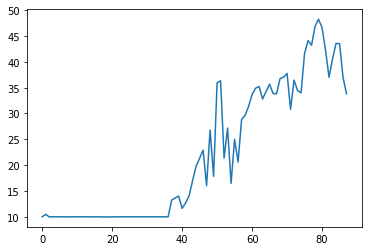

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.077771
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006931
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001734

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 2.008243
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.707101
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.156788

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

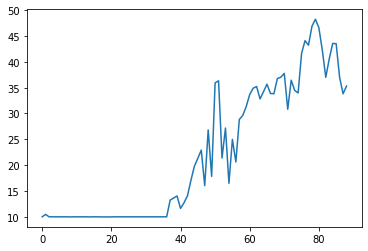

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.047998
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.103437
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003313

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.952198
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.559278
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

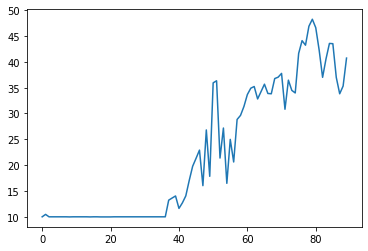

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.064906
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004762
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.007118

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.883264
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000443
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 2.333469

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.125757
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.174530
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.021376

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


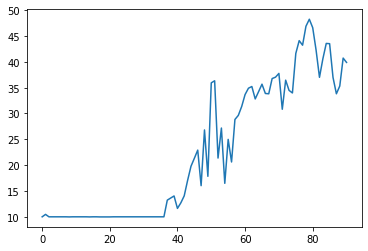

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.116163
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.017852
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000386

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.855638
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.225975
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.026692

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

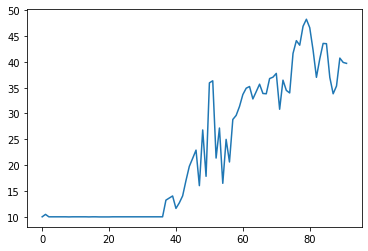

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.007535
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.035349
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000992

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.940183
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.337116
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.196333

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

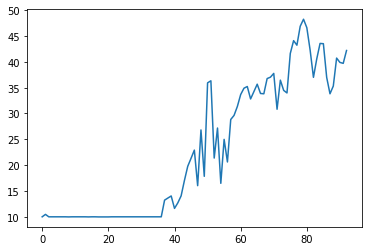

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.037140
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004074
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001237

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.915180
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.327893
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.125724

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

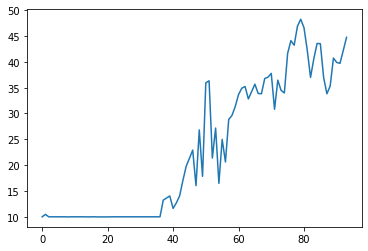

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.009404
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.082594
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.008987

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.942488
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.067392
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.573252

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

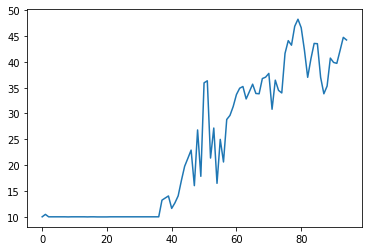

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 2.019473
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.070664
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001944

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.843702
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.156626
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.018420

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

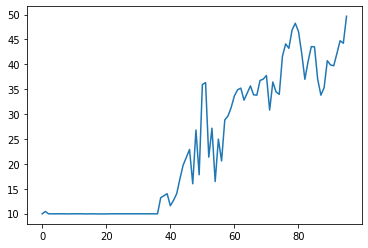

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.952415
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002190
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000187

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.811065
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.387043
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.092795

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

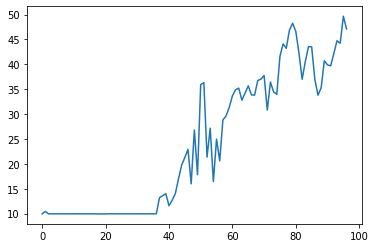

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.996994
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.022816
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000099

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.807878
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.015587
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.067057

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

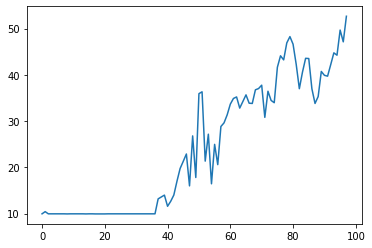

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.888113
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001937
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000046

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.712946
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000411
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000014

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.989446
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.053545
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.106099

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


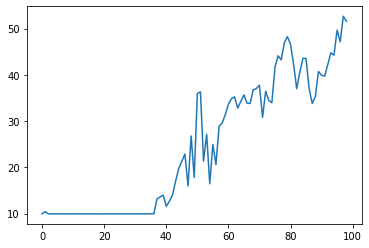

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.782699
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002556
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000039

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.701699
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000211
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

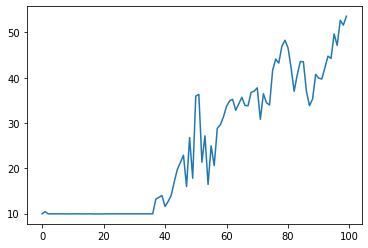

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.847626
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002518
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000003

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.735354
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000369
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

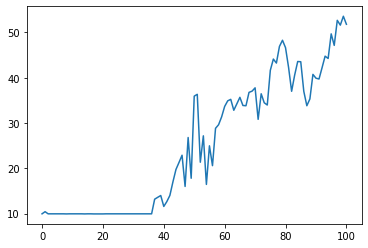

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.860742
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001354
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000022

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.858393
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008204
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000509

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

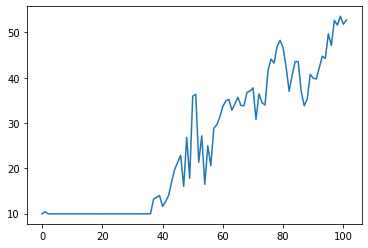

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.851890
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000549
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000012

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.779062
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005620
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 2.076776
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.148101
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001437

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


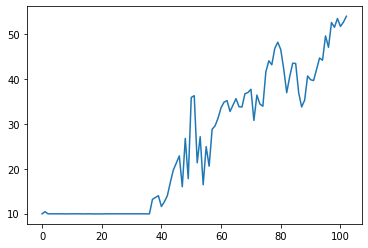

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.853742
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.091928
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000091

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.713715
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000175
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

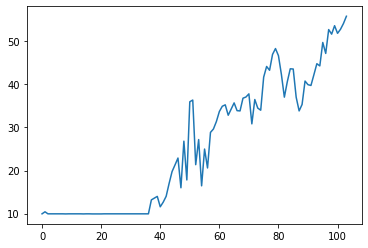

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.837573
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007848
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.711989
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001170
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.903004
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.210142
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.017896

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


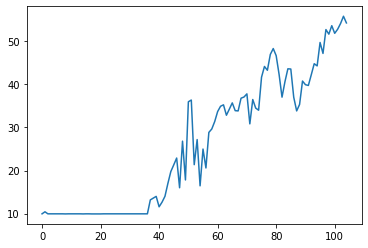

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.671652
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000715
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000025

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.545803
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000108
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

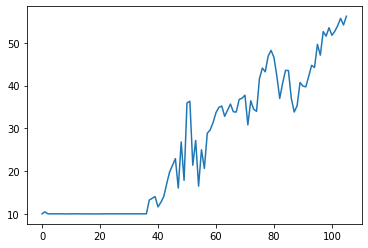

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.766786
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001387
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000003

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.760690
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005240
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

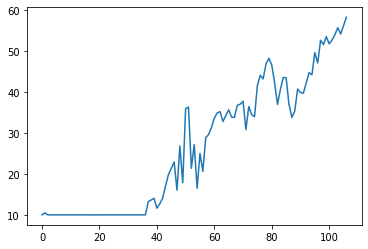

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.689476
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001608
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.633766
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000082
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

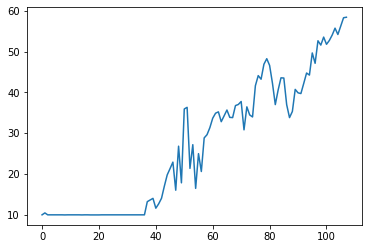

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.784604
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.056284
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.466347
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000706
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.846792
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.499486
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.183054

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


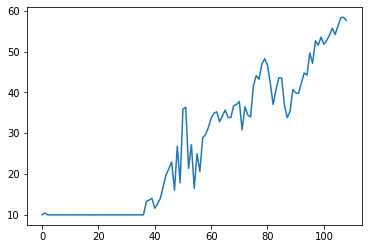

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.619026
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003880
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000094

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.384928
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.012769
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.004951

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

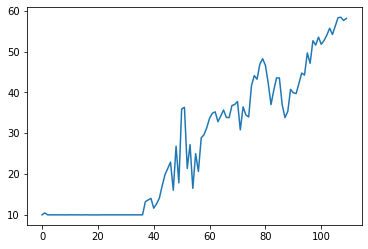

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.557569
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000421
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.440002
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000324
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

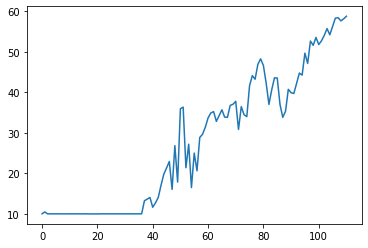

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.570076
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.022961
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.484871
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000148
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.066844

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.773090
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.726441
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.257936

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


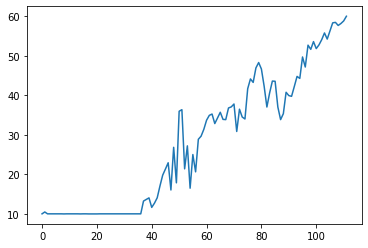

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.538382
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.017919
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000114

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.276060
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000014
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.451677
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.737439
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.095230

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


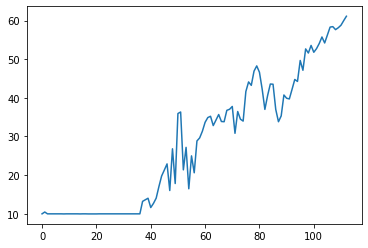

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.467795
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001185
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000041

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.303362
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000168
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.175032
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.029870
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000021

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


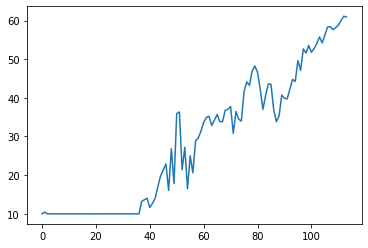

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.488689
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.061639
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000639

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.316426
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000010
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

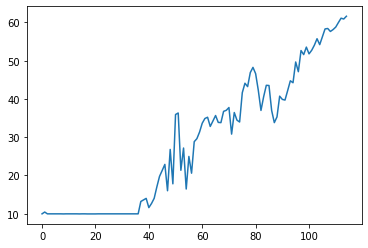

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.456491
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.574881
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000287

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.484154
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000012
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000026

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

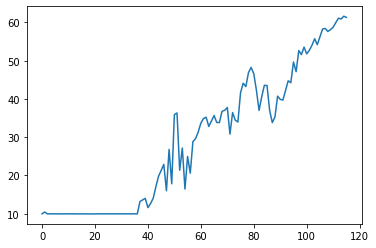

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.368158
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.045661
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003359

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.423748
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000734
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

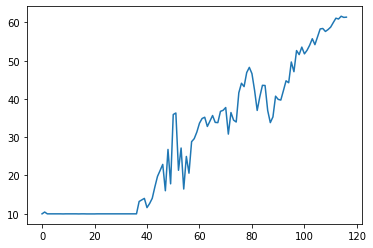

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.443063
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003337
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.136429

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.430351
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000015
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

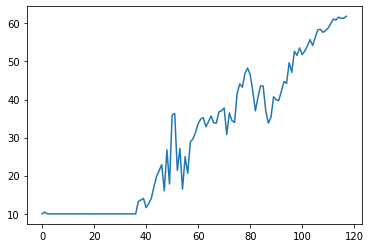

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.427238
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002400
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000482

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.388715
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000008
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

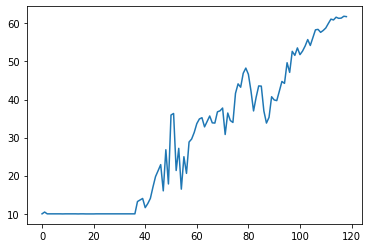

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.281613
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002867
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000096

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.396720
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000006
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

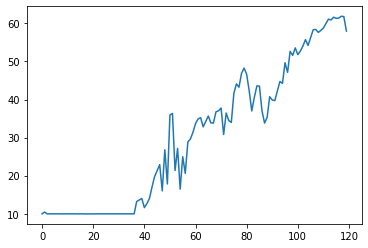

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.589115
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007507
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000129

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.453894
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000057
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.927411
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.370401
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000413

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


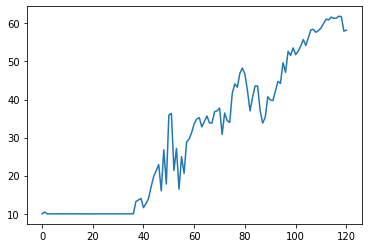

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.627484
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004296
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000053

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.629062
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

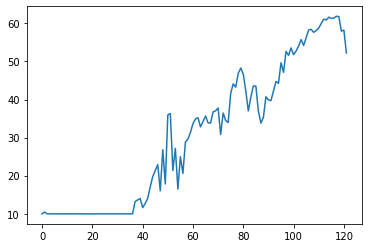

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.717051
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003848
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000091

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.782122
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

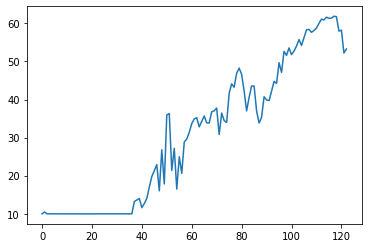

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.626164
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.012455
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000126

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.840202
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

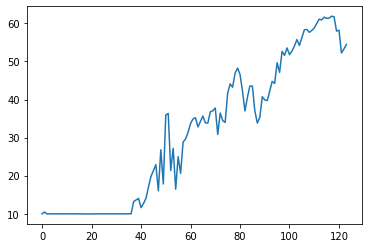

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.735311
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001647
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000402

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.685593
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

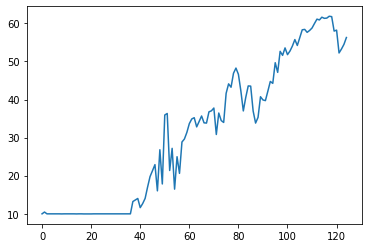

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.577301
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000562
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000041

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.718817
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

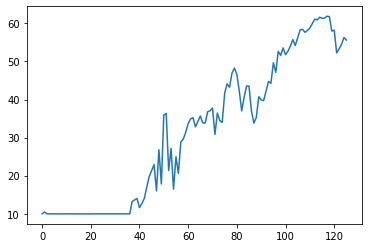

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.617544
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000482
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000064

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.642226
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000004
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

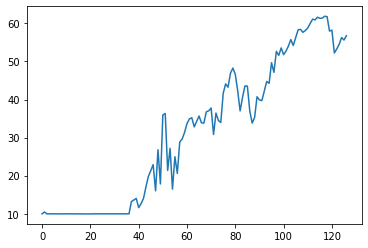

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.667105
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.266254
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000011

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.616522
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000003
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

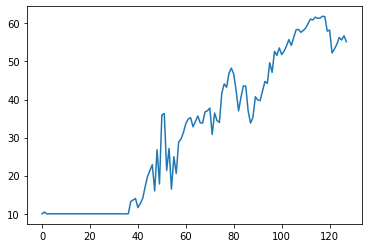

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.582744
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 1.263445
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 3.998262

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.680139
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000003
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

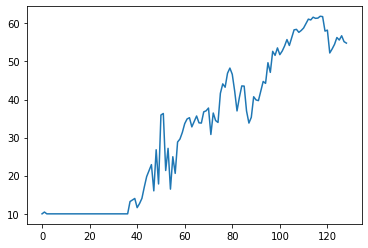

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.680473
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.238096
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.696239

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.629793
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001965
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

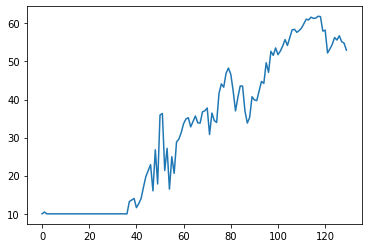

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.670334
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.085601
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.478655

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.761139
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000007
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

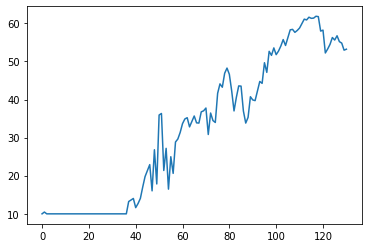

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.673613
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.183625
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.789374
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014560
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.238826

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.946007
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.057100
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.029598

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


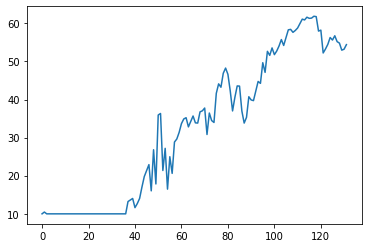

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.655864
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.041119
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000579

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.546976
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003792
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

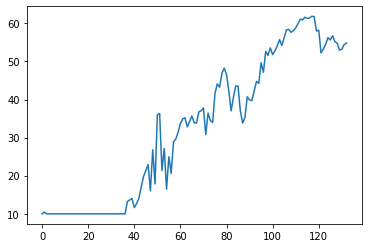

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.578130
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001637
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000010

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.630722
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.758804
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.392786
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


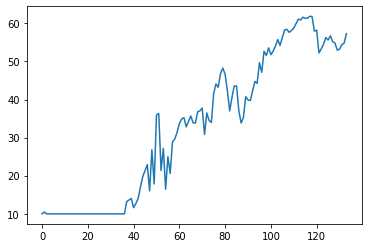

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.477656
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000014
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.433719
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

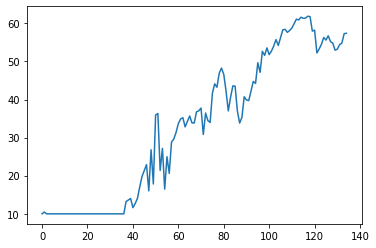

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.488040
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000733
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.628950
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009654
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

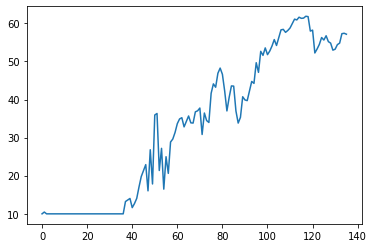

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.386962
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002405
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.435958
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000011
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

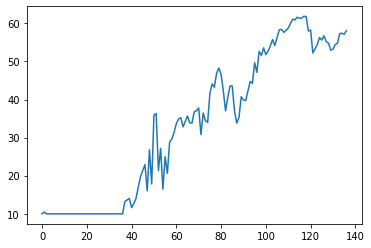

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.344047
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000261
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.576478
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000034
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.892991
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.520302
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.698457

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


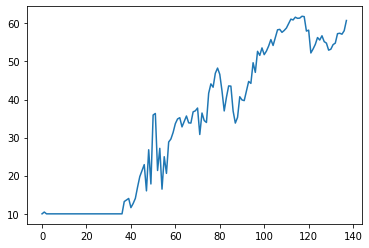

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.286583
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000759
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.325848
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

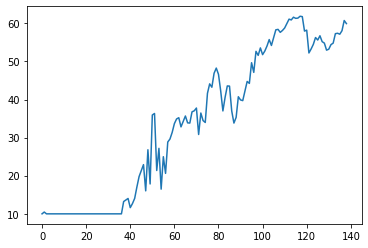

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.342013
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.014980
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000005

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.571993
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000001
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.752098
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.193742
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.098423

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


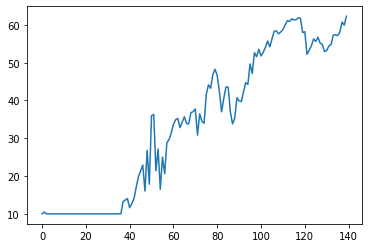

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.167006
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000785
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000003

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.154604
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

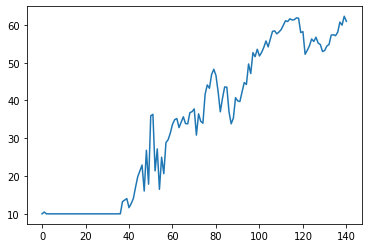

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.353978
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000248
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.410507
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.107983
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.545010

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

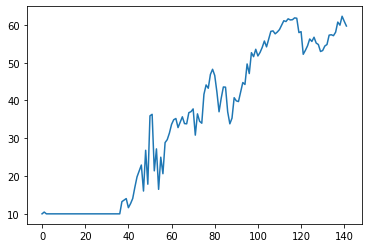

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.387389
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000041
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000009

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.393878
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.211638
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 5.909307

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

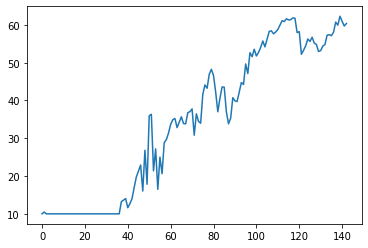

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.367105
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000014
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.455726
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.608944
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.115746

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.694221
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.089455
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


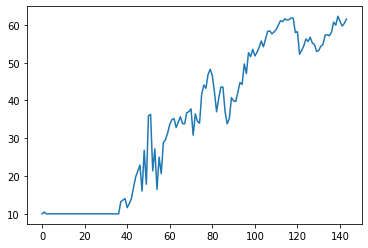

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.330999
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000277
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.332374
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.448946
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.511438

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

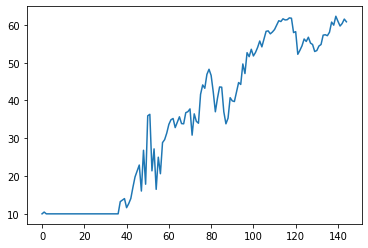

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.334523
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000388
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.443251
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.116468
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.197566

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

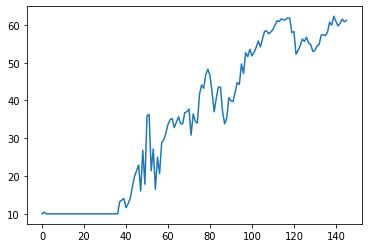

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.562605
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000159
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.318729
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.099967
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.082731

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

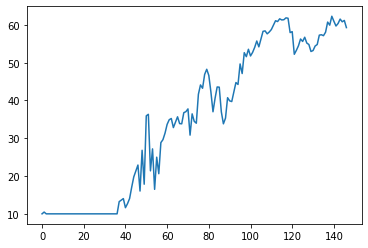

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.436165
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002736
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.567816
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.053251
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.230025

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.773353
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.185872
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.206019

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


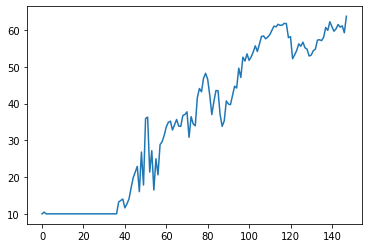

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.426933
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001620
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.341765
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.286024
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.941186

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.455162
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.092752
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


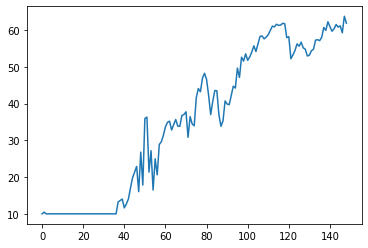

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.284768
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000887
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.258280
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 1.325468
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.007563

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

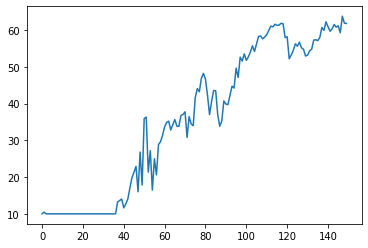

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.254207
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.369917
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.221254
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.189264
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.553985

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

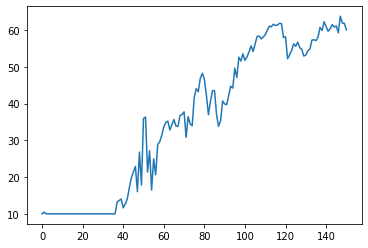

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.333248
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.126293
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 2.288383

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.309812
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.060140
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.214903

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.631765
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009102
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003473

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


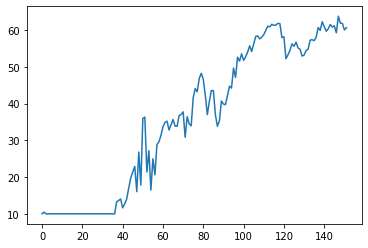

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.539101
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 2.963639
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.288107

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.419151
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.217129
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.112740

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

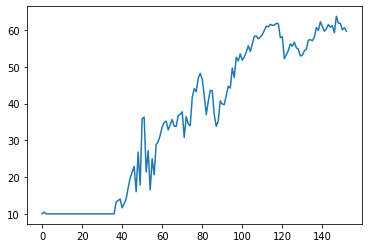

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.426763
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.824751
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 1.173674

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.537193
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.584100
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.355771

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

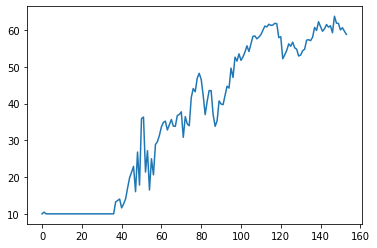

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.617682
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.380964
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.067957

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.586218
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007659
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.132248

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

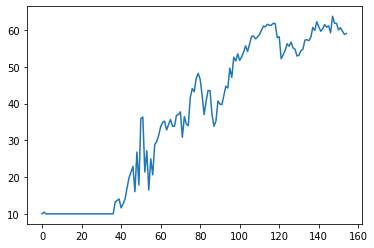

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.649319
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.208582
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.010082

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.551705
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.028643
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.027574

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

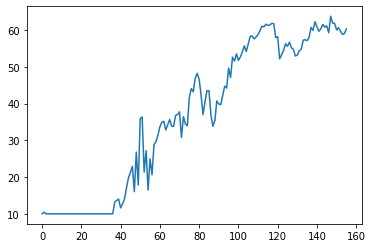

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.429871
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.180856
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.450434

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.361937
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008524
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 1.433892

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

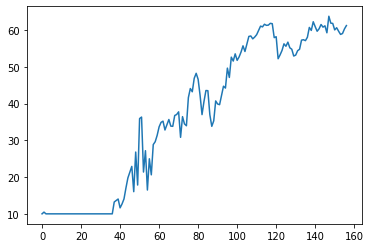

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.547041
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.112511
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.007643

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.320237
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.167174
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.546064

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

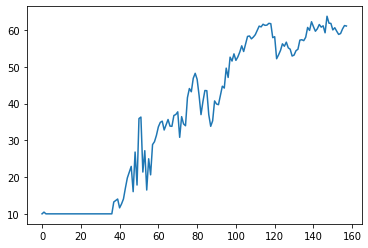

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.487823
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.261092
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.123972

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.372213
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001727
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

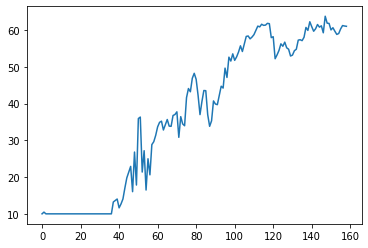

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.366610
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.054478
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.052925

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.554383
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.336898
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

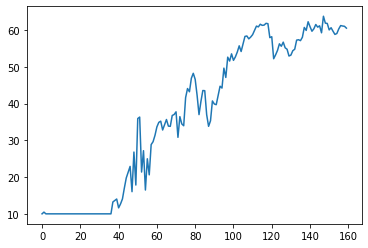

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.485259
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004236
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000808

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.342815
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.099525
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.007909

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

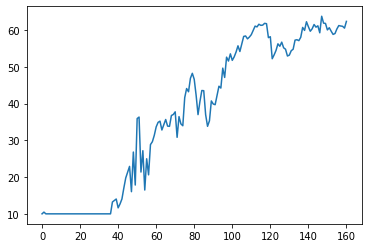

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.452505
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001029
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.120687

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.214896
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000788
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000006

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

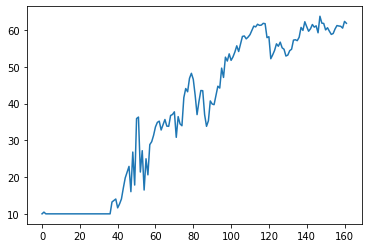

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.422277
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000866
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.123458

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.561188
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000023
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000077

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

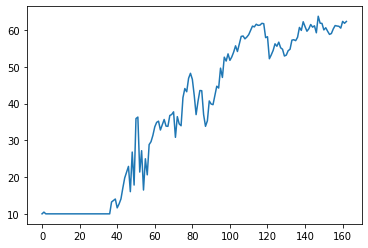

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.604156
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.078653
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.120881

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.455627
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000008
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000163

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

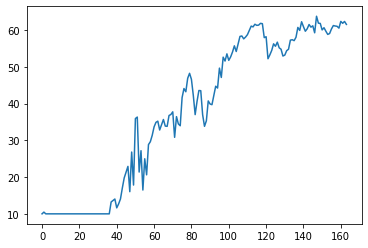

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.259947
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.078236
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000013

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.506400
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.028759
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.754128
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.070764
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000161

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


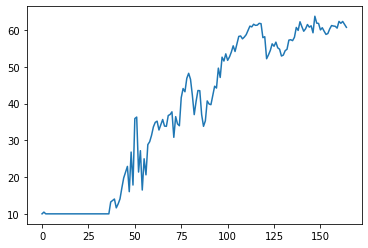

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.219955
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000626
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.103069
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.044927
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

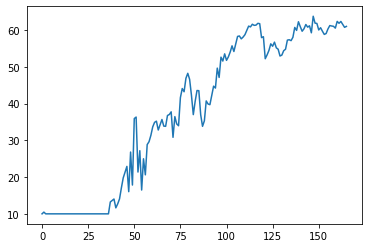

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.253953
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.138102
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.120932

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.183813
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.042522
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000023

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

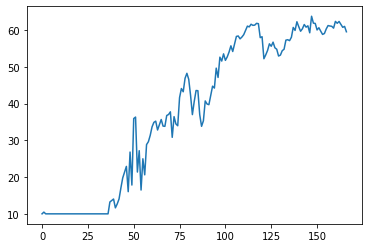

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.450067
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000252
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000031

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.338853
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000005
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

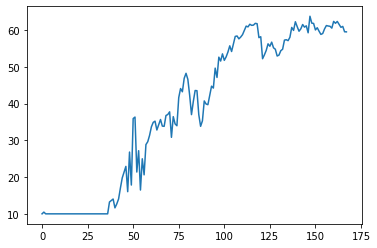

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.409040
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.077895
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000016

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.382879
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000031
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

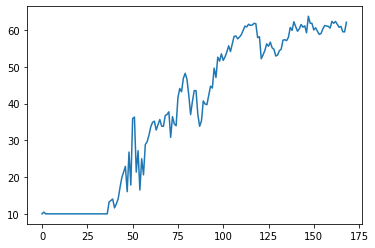

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.384732
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006632
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000035

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.583816
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000035
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000088

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

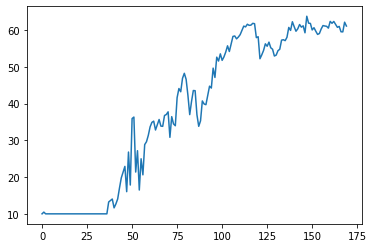

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.534896
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.065395
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001767

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.503402
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.010711
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

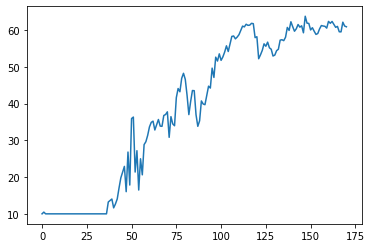

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.342304
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001023
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000017

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.488680
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001281
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

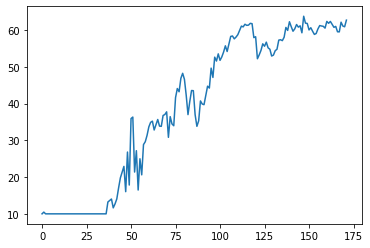

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.392513
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001077
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.122551

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.440687
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.012027
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

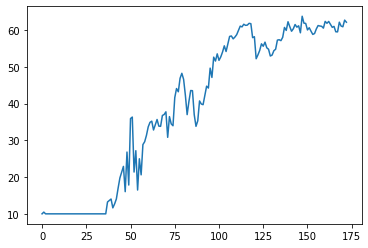

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.209126
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001044
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000009

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.459348
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.009342
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000016

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.520320
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.032759
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000023

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


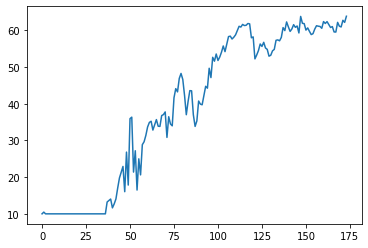

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.367153
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002373
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000006

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.027672
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000104
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.411605
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007333
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


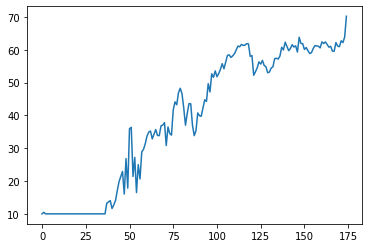

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.466432
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008382
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.122570

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.331505
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.030037
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

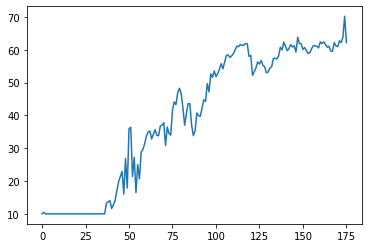

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.178687
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000396
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.249296
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000649
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.375548
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.118120
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.955599

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


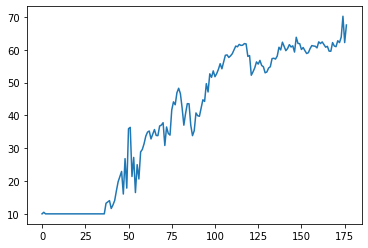

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.280845
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.001555
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000028

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.192067
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000412
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.117786
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.134653
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.001127

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


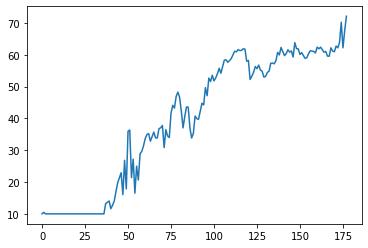

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.174502
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.068272
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.123519

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.411010
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.377660
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.175513
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 1.066895

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


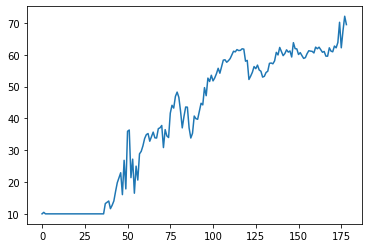

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.213445
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.012330
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 0.939031
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000026
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

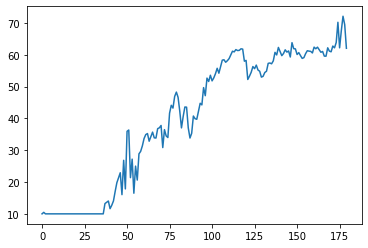

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.114563
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002990
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000102

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.310310
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.024458
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

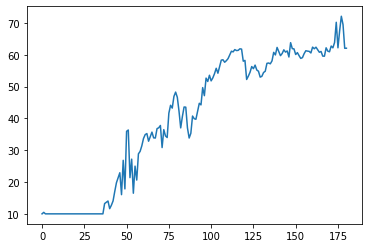

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.080881
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007211
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.272974
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.002585
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

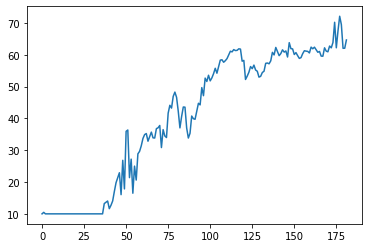

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.438863
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000036
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000005

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.337788
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.023155
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

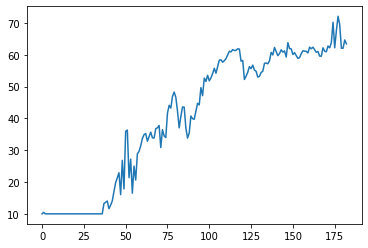

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 0.895686
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.003070
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000005

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.124383
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.007410
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

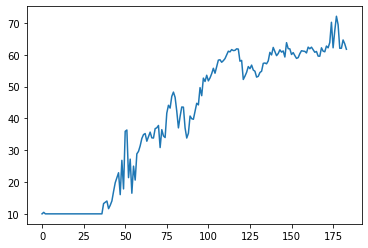

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.149362
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.008371
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000007

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.446002
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.017047
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

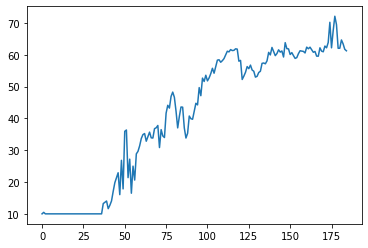

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.122720
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004436
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.286087
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000297
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

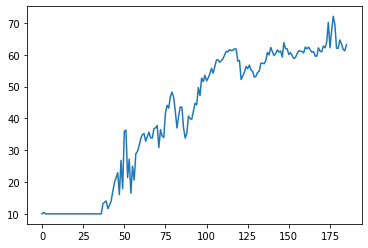

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.204306
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.004631
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.126523

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.325380
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.023349
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

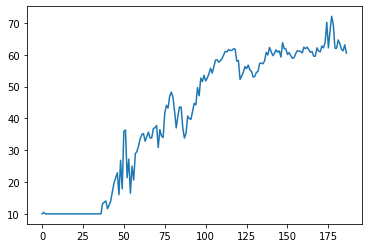

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.019863
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.088911
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000165

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.267344
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.022680
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000029

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.804136
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 1.113014
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.003235

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


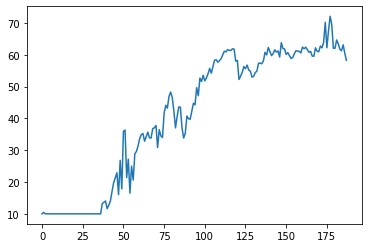

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.205489
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.018726
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000004

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.266325
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.032755
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000410

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

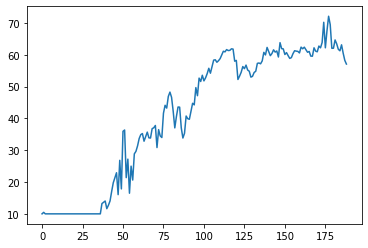

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.332683
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.077051
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000014

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.305144
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.019782
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

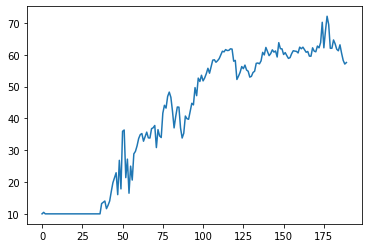

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.164065
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000295
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.126937

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.513973
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.021890
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

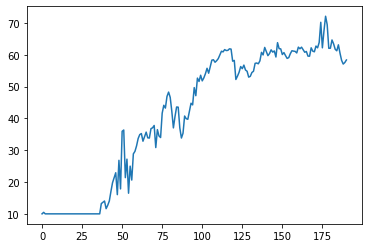

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.307739
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.063754
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000016

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.445192
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.246886
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

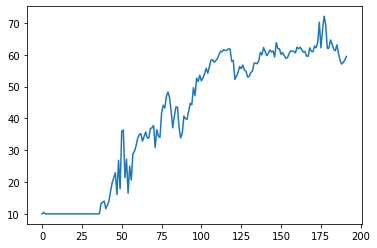

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.288955
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.069662
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000009

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.341013
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

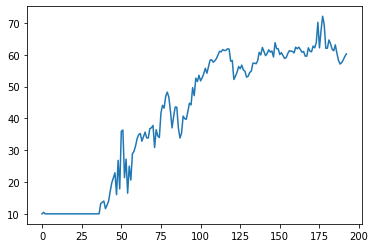

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.260741
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.083116
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000002

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.185483
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000006
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

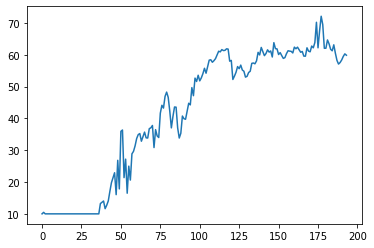

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.181645
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000996
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000013

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.163106
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

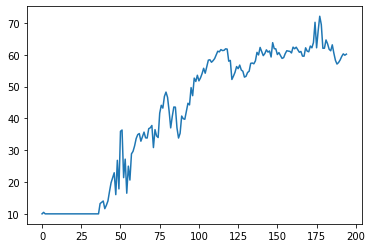

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.282869
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.049002
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.127950

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.319019
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.031736
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Model client6 Train Epoch: 1 [0/320 (0%)]	Loss: 1.690963
Model client6 Train Epoch: 2 [0/320 (0%)]	Loss: 0.352445
Model client6 Train Epoch: 3 [0/320 (0%)]	Loss: 0.030074

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274


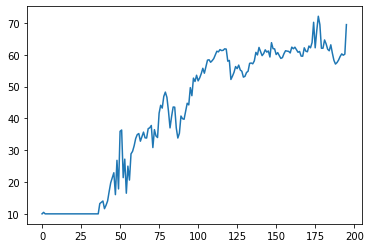

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.462485
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000789
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000020

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.180079
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

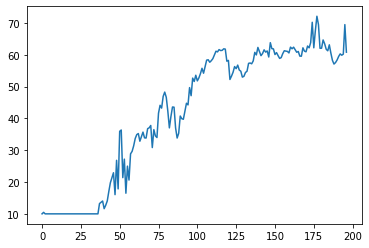

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.316841
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.005506
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.388648
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.006137
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

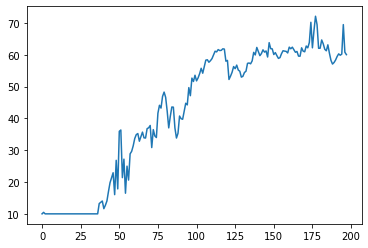

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.095293
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.083848
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000001

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.284654
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.257660
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

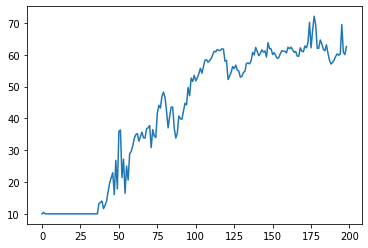

14
14

Power Allocated= 0.8817544972753084
CSI= 0.27439651225502704
SNR= 34.166570777190955
Client: client4
Model client4 Train Epoch: 1 [0/320 (0%)]	Loss: 1.340418
Model client4 Train Epoch: 2 [0/320 (0%)]	Loss: 0.029741
Model client4 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000004

Power Allocated= 1.1646032659077488
CSI= 0.29748514197700404
SNR= 43.327896295506584
Client: client5
Model client5 Train Epoch: 1 [0/320 (0%)]	Loss: 1.321386
Model client5 Train Epoch: 2 [0/320 (0%)]	Loss: 0.000000
Model client5 Train Epoch: 3 [0/320 (0%)]	Loss: 0.000000

Power Allocated= 2.526615565641859
CSI= 0.500125000773699
SNR= 4.741098184269118
Client: client6
Poor Channel, client not taken for averaging in this round

Power Allocated= 0
CSI= 0.21131578892878955
SNR= 29.3887417068798
Client: client7
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.4304585552179274
CSI= 0.9126942822900393
SNR= 22.890513558095257
Client: client10
Model client10 Train Epoch: 1 [0/320 (0%)]	Loss

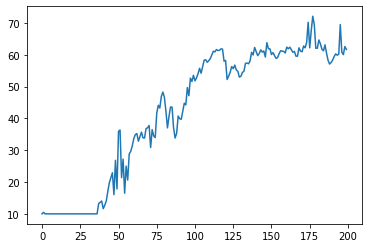

In [11]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)
    
acc1=[]
acc2=[]
acf=[]
rc=1
temp=[]
snrplot=[]
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters=cluster_former()
        temp=copy.deepcopy(arranged_clusters)
    else:
        #print(temp)
        arranged_clusters=copy.deepcopy(temp)
    
    
    
# #     uncomment if you want a random fraction for C every round
# #     args.C = float(format(np.random.random(), '.1f'))
    
#     # number of selected clients
#     m = int(max(args.C * args.clients, 1)) #at least 1 client is selected for training

#     # Selected devices
#     np.random.seed(fed_round)
#     selected_clients_inds = np.random.choice(range(len(clients)), m, replace=False)#dont choose same client more than once
#     selected_clients = [clients[i] for i in selected_clients_inds]
    
#     # Active devices
#     np.random.seed(fed_round)
#     active_clients_inds = np.random.choice(selected_clients_inds, int((1-args.drop_rate) * m), replace=False) #drop clients
#     active_clients = [clients[i] for i in active_clients_inds]
    
    members1=arranged_clusters[0]['Members']
    members2=arranged_clusters[1]['Members']
    print(len(members1))
    print(len(members2))
    new_members1=[]
    new_members2=[]
    
    for ij in members1:
        #print(ij)
        cl_no=int(ij[6:])
        new_members1.append(clients[cl_no-1])
    for ij in members2:
        #print(ij)
        cl_no=int(ij[6:])
        new_members2.append(clients[cl_no-1])
    
    arranged_clusters[0]['Members']=new_members1
    arranged_clusters[1]['Members']=new_members2
    
    cl_no=int(arranged_clusters[0]['Cluster Head'][6:])
    arranged_clusters[0]['Cluster Head']=clients[cl_no-1]
    cl_no=int(arranged_clusters[1]['Cluster Head'][6:])
    arranged_clusters[1]['Cluster Head']=clients[cl_no-1]
        
        
        
    #training members of individual clusters and considering cluster head as the global server for the time slot
    no=1
    
    for cluster in arranged_clusters:  
        client_good_channel=[] #to check which clients have a good channel, only those will be taken for averaging per round
        members=cluster['Members']
        snrlist=cluster['SNR']
        csilist=cluster['CSI']
        head=cluster['Cluster Head']
        snr=[]
        csi=[]
        for i in snrlist:
            snr.append(i[2])
        for i in csilist:
            csi.append(i[2])
        print()
        #print(csi)
        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csi:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
         
        good_mem=[]

        index=0
        for client in members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snr[index],csi[index],smallmu1)
            index+=1
            if(goodchannel):
                good_mem.append(client)


        head['model']=averageModels(head['model'], good_mem)
        ac=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        no+=1
        # for client in members:
        #     client['model'].load_state_dict(head['model'].state_dict())
        # cluster['Members']=members
        # cluster['Cluster Head']['model'].load_state_dict(head['model'].state_dict())
        
        # if(cluster==arranged_clusters[0]):
        #     acc1.append(ac)
        # elif(cluster==arranged_clusters[1]):
        #     acc2.append(ac)
    
    # if(acc1[-1]>=acc2[-1]):
    #     head=arranged_clusters[0]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # else:
    #     head=arranged_clusters[1]["Cluster Head"]
    #     index=0
    #     for client in clients:
    #         client['model'].load_state_dict(head['model'].state_dict())
    #         client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #         index+=1
    # acf.append(test(args,head['model'], device, global_test_loader, "Final",fed_round))


    snrsum1=0
    snrsum2=0
    for k in snrlist:
        if(arranged_clusters[0]["Cluster Head"]['hook'].id in k):
            snrsum1+=k[2]
        else:
            snrsum2+=k[2]
    
    #print(snrsum1,snrsum2)

    weight1=snrsum1/(snrsum1+snrsum2)
    weight2=snrsum2/(snrsum1+snrsum2)
    snrplot.append((snrsum1+snrsum2)/len(snrlist))
    
    head1=arranged_clusters[0]["Cluster Head"]
    head2=arranged_clusters[1]["Cluster Head"]
    
    overall=averageModelscluster(overall,[head1,head2],[weight1,weight2])
    acf.append(test(args,overall, device, global_test_loader, "Final ",fed_round))
    index=0
    # for client in clients:
    #     client['model'].load_state_dict(overall.state_dict())
    #     client=CLientReturn(client,snr[index],csi[index],smallmu1)
    #     index+=1
    for client in clients:
        client['model'].load_state_dict(overall.state_dict())
        #client=CLientReturn(client,snr[index],csi[index],smallmu1)  #CHANGE: commented
        index+=1





    print(rc)
    rc+=1
    
    fig,ax=plt.subplots()
    ax.plot([i for i in range(len(acf))],acf)
    plt.show()
plt.show()
#plt.savefig('result_cluster.png')

In [12]:
print(acf)
print(snrplot)

[9.96, 10.43, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.94, 9.96, 9.96, 9.96, 9.96, 9.96, 9.94, 9.96, 9.96, 9.94, 9.94, 9.94, 9.94, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 9.96, 13.19, 13.6, 14.0, 11.59, 12.66, 14.02, 17.0, 19.75, 21.3, 22.89, 16.0, 26.8, 17.81, 35.93, 36.33, 21.35, 27.17, 16.45, 24.97, 20.59, 28.83, 29.62, 31.35, 33.66, 34.89, 35.22, 32.81, 34.23, 35.67, 33.87, 33.81, 36.76, 37.03, 37.76, 30.81, 36.45, 34.47, 33.97, 41.63, 44.11, 43.23, 46.9, 48.26, 46.62, 42.26, 37.0, 40.58, 43.57, 43.52, 36.99, 33.81, 35.31, 40.73, 39.89, 39.71, 42.2, 44.75, 44.24, 49.67, 47.13, 52.66, 51.6, 53.56, 51.79, 52.73, 54.06, 55.75, 54.2, 56.25, 58.31, 58.43, 57.65, 58.14, 58.79, 59.98, 61.12, 60.91, 61.63, 61.33, 61.39, 61.88, 61.78, 57.98, 58.23, 52.23, 53.28, 54.49, 56.29, 55.63, 56.75, 55.21, 54.82, 52.97, 53.22, 54.42, 54.82, 57.3, 57.41, 57.16, 58.08, 60.76, 59.95, 62.31, 60.97, 59.72, 60.39, 61.56, 60.84, 61.2, 59.3, 63.81, 61.93, 61.85,